In [10]:
#2 Hydrogen atoms with Lennard-Jones potential

In [3]:
import numpy as np
from abc import ABCMeta
from abc import abstractmethod
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

In [4]:
NA = 6.02e23
ev = 1.60218e-19

In [5]:
plt.rcParams['font.family'] = 'sans-serif'  # 
plt.rcParams['xtick.direction'] = 'in'

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.0  
plt.rcParams['ytick.major.width'] = 1.0  
plt.rcParams['font.size'] = 25  
plt.rcParams['axes.linewidth'] = 1.0  


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.92, 'Visualization')

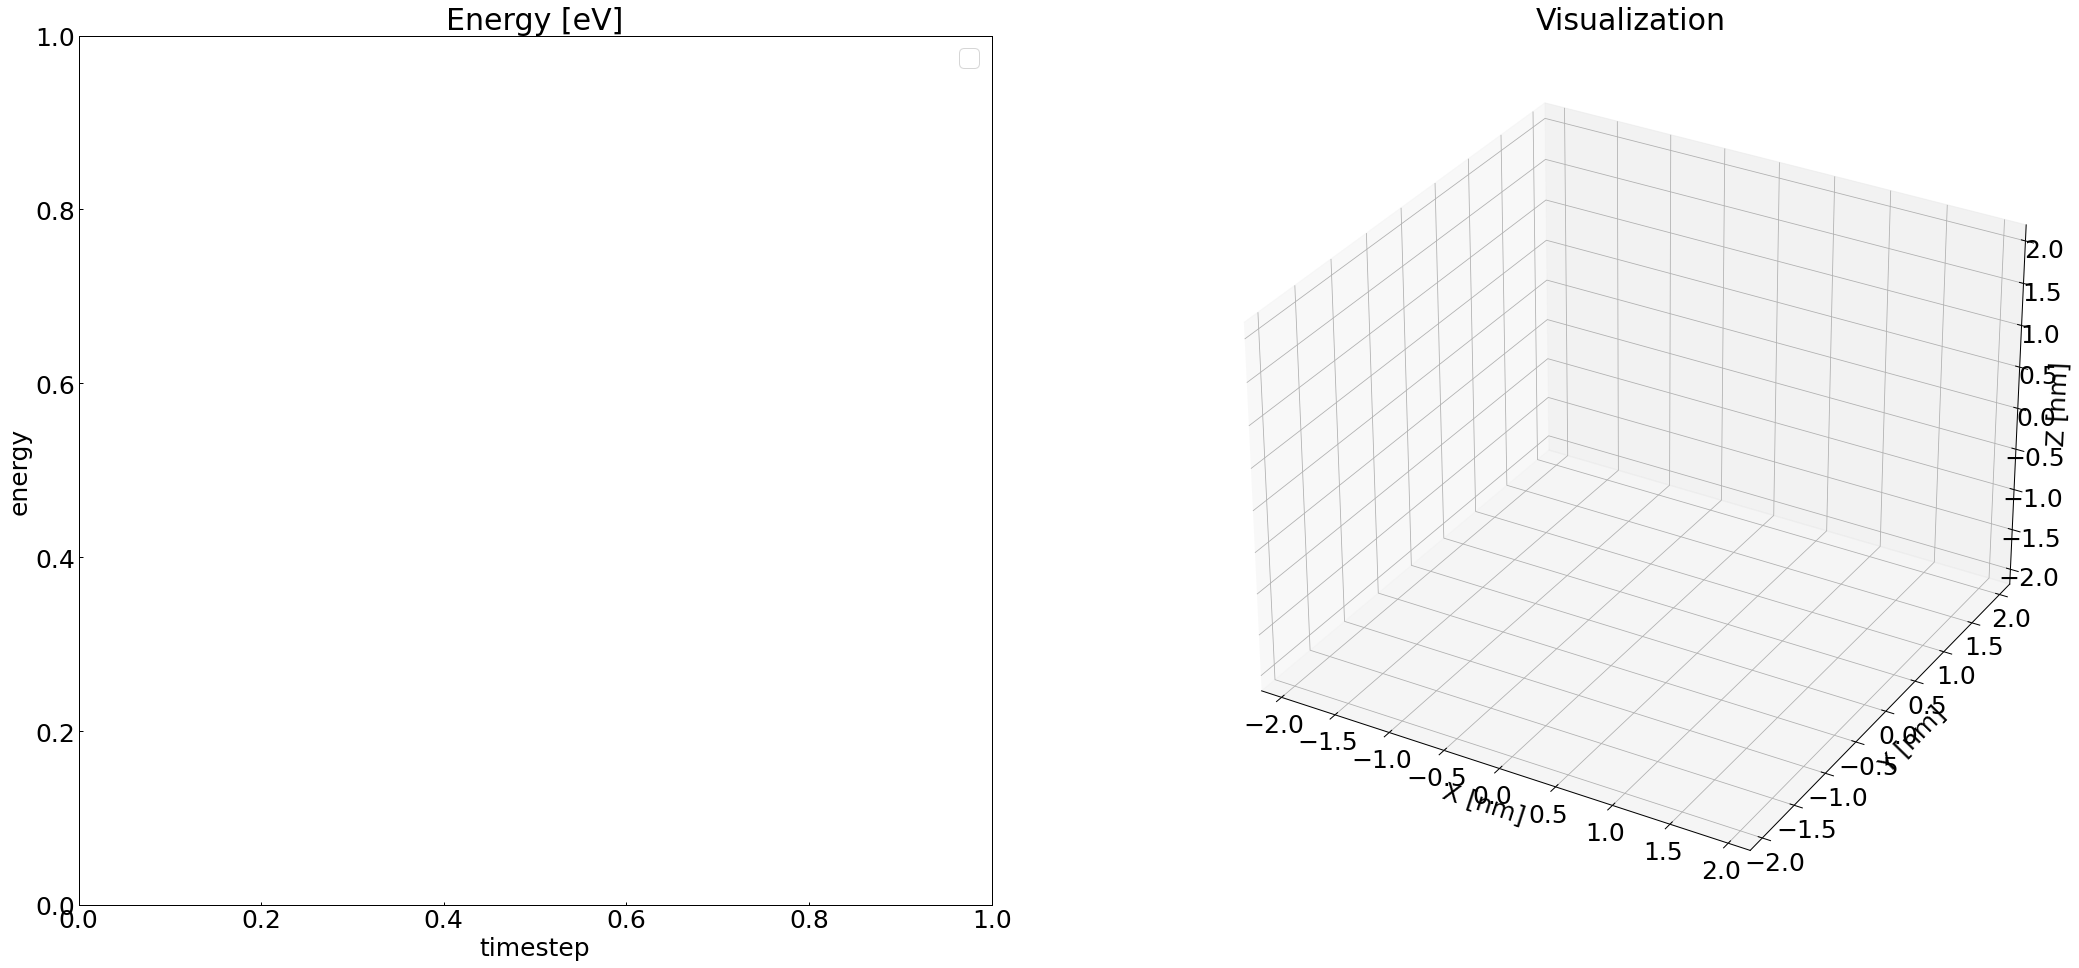

In [6]:
fig = plt.figure(figsize=(36, 16))
energy = fig.add_subplot(121)
cordinate = fig.add_subplot(122, projection='3d')
energy.set_xlabel('timestep')
energy.set_ylabel('energy')
energy.legend(loc='upper right')
energy.set_title('Energy [eV]')

cordinate.set_xlabel('X [nm]')
cordinate.set_xlim(-2.1, 2.1)
cordinate.set_ylabel('Y [nm]')
cordinate.set_ylim(-2.1, 2.1)
cordinate.set_zlabel('Z [nm]')
cordinate.set_zlim(-2.1, 2.1)
cordinate.set_title('Visualization')


In [7]:
class Atom:
    def __init__(self,M):
        self.pos=None
        self.vel=None
        self.M=M #mass
    
    def set_initial_condition(self,px,py,pz):
        self.pos=np.array([px,py,pz])
        self.vel = np.array([0,0,0])
        return 
        
    def move(self):
        self.pos=self.pos+self.vel

In [8]:
class Potential(metaclass=ABCMeta):
   @abstractmethod
   def energy(self):
      pass

   @abstractmethod
   def force(self):
      pass

class LJ:
    def __init__(self,eps,delta):
        self.eps=eps
        self.delta=delta
        return None

    def energy(self,x:Atom, y:Atom)->np.array:
        r=np.sqrt(np.sum((x.pos-y.pos)**2))
        del_r = self.delta/r
        pot=4*self.eps*((del_r**12)-(del_r**6))
        return pot
    
    def force(self,x:Atom, y:Atom)->np.array:
        r = np.sqrt(np.sum((x.pos-y.pos)**2))
        dvdr=4*self.eps*(6*(self.delta**6)/r**7-12*(self.delta**12)/r**13)
        dxdydz=-dvdr*(x.pos-y.pos)/r
        return dxdydz


In [9]:
class System:
    def __init__(self):
        self.Atoms=[]
        self.K=0
        self.P=0
        self.E=0
        self.pot = LJ(0.00789*ev, 0.368e-9)  # J,m

    def add_atoms(self,M,px,py,pz):
        new_atom = Atom(M)
        new_atom.set_initial_condition(px, py, pz)
        self.Atoms.append(new_atom)
    
    def kinetic_energy(self):
        for x in self.Atoms:
            self.K=self.K+np.sum(x.vel**2*x.M)/2
        return self.K
    
    def potential_energy(self):
        for i,x in enumerate(self.Atoms):
            for j,y in enumerate(self.Atoms):
                if i == j:
                    pass
                else:
                    self.P =self.P+ self.pot.energy(x,y)
        return self.P
    
    def update_velocity(self):
        for i,x in enumerate(self.Atoms):
            total_force=0
            for j, y in enumerate(self.Atoms):
                if i == j:
                    pass
                else:
                    total_force+=self.pot.force(x,y)
            x.vel=x.vel+total_force
    
    def update_position(self):
        for x in self.Atoms:
            x.move()
    
    def total_energy(self):
        self.E=self.kinetic_energy()+self.potential_energy()
        return self.E

In [10]:
class Traj:
    def __init__(self, iter, atom_num):
        self.df = pd.DataFrame(columns=["timestep", "E", "K", "P"])
        self.atom_traj = []
        for x in range(atom_num):
            new_atom_df = pd.DataFrame(
                columns=["p_x", "p_y", "p_z", "v_x", "v_y", "v_z"])
            self.atom_traj.append(new_atom_df)
    
    def observe(self,system,i):
        series=pd.Series([i, system.total_energy(), system.K, system.P],index=self.df.columns)
        self.df=self.df.append(series, ignore_index=True)
        for i,x in enumerate(self.atom_traj):
            series_a = pd.Series(
                np.array([system.Atoms[i].pos.flatten(), system.Atoms[i].vel.flatten()]).flatten(), index=x.columns)
            self.atom_traj[i] = self.atom_traj[i].append(
                series_a, ignore_index=True)


In [11]:
class MD:
    def __init__(self,T,iter,atom_num):
        self.system=System()
        self.T=T #Temperature
        self.iter=iter
        self.time=0
        self.traj=Traj(iter,atom_num)
        
    def add_atom(self,atom_list):
        for val in atom_list:
            self.system.add_atoms(val["M"], val["px"], val["py"], val["pz"])

    def Run(self):
        for i in range(self.iter):
            self.system.update_velocity()
            self.system.total_energy()
            self.system.update_position()
            if i%10 ==0:
                self.traj.observe(self.system,i)

In [17]:


atom_list = [{
    "M": 1e-3/NA, #kg
    "px": 0,
    "py": 0,
    "pz": 0
},
    {
    "M": 1e-3/NA,#kg
    "px": 2e-9,  # nm
    "py": 0,
    "pz": 0
},
    {
    "M": 1e-3/NA,  # kg
    "px": 0,  # nm
    "py": 2e-9,
    "pz": 0
},
    {
    "M": 1e-3/NA,  # kg
    "px": 0,  # nm
    "py": 0,
    "pz": 2e-9 #m
},
    {
    "M": 1e-3/NA,  # kg
    "px": -2e-9,  # nm
    "py": 0,
    "pz": 0
},
    {
    "M": 1e-3/NA,  # kg
    "px": 0,  # nm
    "py": -2e-9,
    "pz": 0
},
    {
    "M": 1e-3/NA,  # kg
    "px": 0,  # nm
    "py": 0,
    "pz": -2e-9  # m
},
]
num_atoms=7
timestep=5000


In [18]:
MD_=MD(120,timestep,num_atoms)
MD_.add_atom(atom_list)
MD_.Run()

In [19]:
df=MD_.traj.df
atom_df=MD_.traj.atom_traj

In [20]:
atom_df[1]

,p_x,p_y,p_z,v_x,v_y,v_z
0,1.999999e-09,0.000000e+00,0.000000e+00,-7.403972e-16,0.000000e+00,0.000000e+00
1,1.999951e-09,0.000000e+00,0.000000e+00,-8.144791e-15,0.000000e+00,0.000000e+00
2,1.999829e-09,0.000000e+00,0.000000e+00,-1.555130e-14,0.000000e+00,0.000000e+00
3,1.999633e-09,0.000000e+00,0.000000e+00,-2.296183e-14,0.000000e+00,0.000000e+00
4,1.999362e-09,0.000000e+00,0.000000e+00,-3.037833e-14,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
495,5.299946e-08,1.284159e-08,7.659588e-10,1.448383e-11,3.544590e-12,2.124953e-13
496,5.314429e-08,1.287703e-08,7.680837e-10,1.448383e-11,3.544590e-12,2.124953e-13
497,5.328913e-08,1.291248e-08,7.702087e-10,1.448383e-11,3.544590e-12,2.124953e-13
498,5.343397e-08,1.294792e-08,7.723336e-10,1.448383e-11,3.544590e-12,2.124953e-13


In [25]:

t=[]
P=[]
K=[]
V=[]

def run(i):
    cordinate.clear()
    energy.clear()
    plt.rcParams['font.family'] = 'sans-serif'  # 使用するフォント
    # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['xtick.direction'] = 'in'
    # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.major.width'] = 1.0  # x軸主目盛り線の線幅
    plt.rcParams['ytick.major.width'] = 1.0  # y軸主目盛り線の線幅
    plt.rcParams['font.size'] = 25  # フォントの大きさ
    plt.rcParams['axes.linewidth'] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
    
    t.append(df["timestep"].loc[i])
    K.append(df["K"].loc[i]/ev)
    V.append(df["E"].loc[i]/ev)
    P.append(df["P"].loc[i]/ev)
    energy.plot(t, K, label='Kinetic energy')
    energy.plot(t, P, label='Potential energy')
    energy.plot(t, V, label='Total energy')
    energy.set_xlim(0, timestep)
    for y in range(len(atom_list)):
        pos=atom_df[y].loc[i]
        cordinate.scatter(pos["p_x"]/1e-9, pos["p_y"]/1e-9, pos["p_z"]/1e-9, s=500)
    cordinate.set_xlim(-2.1, 2.1)
    cordinate.set_ylim(-2.1, 2.1)
    cordinate.set_zlim(-2.1, 2.1)
    cordinate.set_xlabel('X [nm]')
    cordinate.set_ylabel('Y [nm]')
    cordinate.set_zlabel('Z [nm]')
    cordinate.set_title('Visualization')
    energy.set_xlabel('timestep')
    energy.set_ylabel('energy')
    energy.legend(loc='upper right')
    energy.set_title('Energy [eV]')

ani = FuncAnimation(fig, run, frames=500, interval=10, repeat=False)
ani.save("ani.mp4")
